# dggridpy: Discrite Global Grids for Python

Every time we want to analyse events and correlate them with environmental data, doing spatial statistics, especially on a global scale, we are faced with the limitations of rectangular grids based on polar coordinates or local metric grids.

Latitude/longitudes are perfect to identify points on the sphere, but are not ideal to subdivide regions since they introduce distortions that introduce a bias in the analysis. Metric grids on the other hand are valid for relatively small areas, and start showing the same problems when the reference grids grow.

These distortions are always present, and introduce a bias also when presenting results on maps due to the distortion introduced by the projection used to represent a sphere on a 2D medium (i.e. the screen).

Discrete Global Grid Systems ([DGGS](http://www.opengeospatial.org/projects/groups/dggsswg) for short) allow to subdivide the Earth's sphere in equal size regions that can be used to index or bin geospatial data into homogeneous bins.

In this notebook we will show how to use DGGS to bin earthquackes events around the globe. The DGGS used here is the [ISEA4H](https://webpages.sou.edu/~sahrk/dgg/isea.old/tables/isea4htbl.html) (but other can be used). The ISEA4H DGG provides a hierarchical tesellation based on a mixed hexagons/pentagons tiles. The resolution used (i.e. 4) provides 2,562 cells of 199,244.483 sq. km size each:

![ISEA4H](image/ISEA4H.png) 

We start by importing `dggridpy` and few other packages we will used later on for data wrangling and visualization: 

In [37]:
import dggridpy as dg
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

vert0 = {
    'lat' : 0.0,
    'lon':  0.0
}
azimuth = 0.0
resolution = 4
aperture=4
topology="HEXAGON"
projection="ISEA"


Then we can import `pandas` and use it to load a data set with the earthquackes of magnitude greater than 2.5 registered in the year 2018. The data has been downloaded from [UGSG](https://earthquake.usgs.gov/earthquakes/).

The latitude and longitude of the earthquackes' epicenters are then used to generate the cell sequence number in the used DGGS (i.e. ISEA4H resolution 3):

```
seqs = dg.GEO_to_SEQNUM(isea , dgquackes['longitude'] , dgquackes['latitude'])
```

Afterwards, the events are grouped by cell sequence number and the events are counted.

In [38]:
import pandas
dgquackes = pandas.read_csv("usgc_earthquackes_2018.csv")

isea = dg.DGGSParam(
    vert0['lon'] , 
    vert0['lat'] , 
    azimuth , 
    aperture , 
    resolution , 
    dg.TopologyType.HEXAGON,
    dg.ProjectionType.ISEA)

seqs = dg.GEO_to_SEQNUM(isea , dgquackes['longitude'] , dgquackes['latitude'])

dgquackes['cell'] = seqs

stats = dgquackes.groupby(['cell']).size().reset_index(name='counts')

stats['counts'].describe()


count      736.000000
mean        60.220109
std        622.663553
min          1.000000
25%          2.000000
50%          6.000000
75%         19.000000
max      16176.000000
Name: counts, dtype: float64

Once the earth quackes events have been binned and counted, we can then show them on a map using matplotlib. 

In order to show the bin regions on the whole globe we use near-side perspective CRS focused on different points on the globe. The color map is based on a log distribution of the counts.


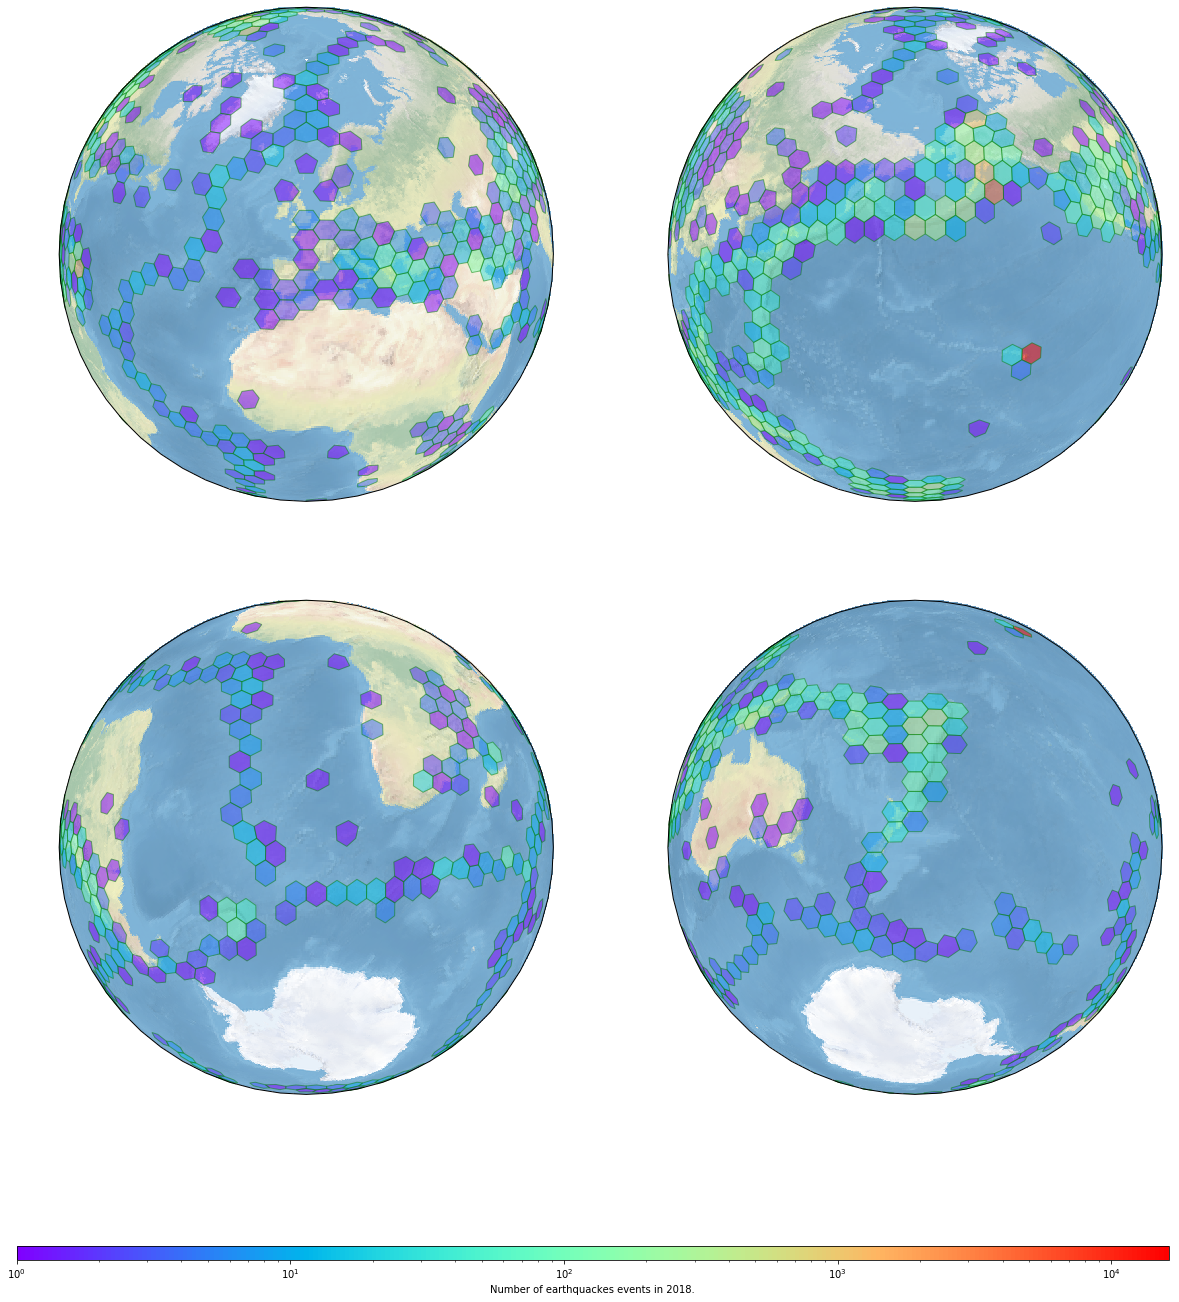

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import branca.colormap as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize , LogNorm
from matplotlib.cm import ScalarMappable

plt.close()
plt.figure(1,figsize=(20,20))
fig = plt.gcf()    

desired_projections = [ ccrs.NearsidePerspective(central_longitude=0 , central_latitude =45),
                        ccrs.NearsidePerspective(central_longitude=180 , central_latitude =45),
                        ccrs.NearsidePerspective(central_longitude=0 , central_latitude =-45),
                        ccrs.NearsidePerspective(central_longitude=180 , central_latitude =-45)
                      ]

linear = plt.cm.rainbow
norm=LogNorm(vmin=min(stats['counts']), vmax=max(stats['counts']))
mapper = ScalarMappable(norm=norm, cmap=linear)

for plot_num, desired_proj in enumerate(desired_projections):
    ax = plt.subplot(2 , 2 , plot_num+1 , projection=desired_proj)
    ax.set_global()
    for index , row in stats.iterrows():
        verts = dg.SeqNumGrid(isea ,int(stats.at[index,'cell']))
        for cell in verts:
            mpoly = mpatches.Polygon(
                xy=verts[cell].tolist(), 
                closed=True , 
                facecolor=mapper.to_rgba(stats.at[index,'counts']),
                edgecolor="green",
                alpha=0.5,
                animated=True,
                linewidth=1,
                transform=ccrs.Geodetic())            
            ax.add_patch(mpoly)            
    ax.stock_img()

cax = fig.add_axes([0.1, 0.01, 0.8, 0.01])
cb = ColorbarBase(cax,cmap=linear, norm=norm, orientation='horizontal')
cb.ax.set_xlabel('Number of earthquackes events in 2018.')
plt.show()
